In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Download PBP
seasons = range(2011,2026)
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (likely large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: range(2011, 2026)
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Rows loaded: 722172


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2011_01_ATL_CHI,2011091105,CHI,ATL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2011_01_ATL_CHI,2011091105,CHI,ATL,REG,1,CHI,home,ATL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69.0,2011_01_ATL_CHI,2011091105,CHI,ATL,REG,1,CHI,home,ATL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.0,2011_01_ATL_CHI,2011091105,CHI,ATL,REG,1,CHI,home,ATL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112.0,2011_01_ATL_CHI,2011091105,CHI,ATL,REG,1,CHI,home,ATL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [4]:
cols_to_keep = ['play_type', 'play_type_actual', 'season', 'home_wp_post', 'away_wp_post', 'weather', 'yardline_100', 'ydstogo',
               'game_seconds_remaining', 'half_seconds_remaining', 'posteam', 'defteam',
               'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'kick_distance', 'touchback',
                'return_yards', 'first_down', 'touchdown', 'temp_F', 'wind_mph', 'game_id', 'score_differential',
                'home_team', 'away_team', 'home_score', 'away_score', 'down', 'field_goal_result', 'penalty',
               'home_coach', 'away_coach']

In [5]:
pbp = raw_pbp.copy()

action_to_col = {
    "punt": "punt",
    "field_goal": "field_goal",
    "run": "go",
    "pass": "go"
}

pbp["play_type_actual"] = pbp["play_type"].map(action_to_col)
pbp = pbp[pbp.play_type_actual.isin(['punt', 'go', 'field_goal'])]
pbp = deconstruct_weather(pbp)
pbp = pbp[cols_to_keep].copy()
pbp = pbp[pbp.penalty == 0]
pbp['fg_made'] = (pbp["field_goal_result"] == "made").astype(int)

action_to_ewp_col = {
    "punt": "ewp_punt",
    "field_goal": "ewp_fg",
    "go": "ewp_go_adj"
}
pbp["actual_ewp_col"] = pbp["play_type_actual"].map(action_to_ewp_col)

pbp["possession_coach"] = np.where(
    pbp["posteam"] == pbp["home_team"],
    pbp["home_coach"],
    pbp["away_coach"]
)

pbp["defending_coach"] = np.where(
    pbp["posteam"] == pbp["home_team"],
    pbp["away_coach"],
    pbp["home_coach"]
)

In [6]:
seasons = pbp.season.unique() # seasons
test_season = seasons.max()

pbp_train = pbp[pbp.season != test_season]
pbp_test = pbp[pbp.season == test_season]

In [7]:
def make_temporal_folds(df, season_col="season", min_train_seasons=3):
    """
    Expanding-window CV folds by season.
    Returns list of (train_idx, val_idx).
    """
    seasons = np.sort(df[season_col].unique())
    folds = []

    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]

        train_idx = df[df[season_col].isin(train_seasons)].index
        val_idx = df[df[season_col] == val_season].index

        folds.append((train_idx, val_idx))

    return folds

In [8]:
# --- Drop rows missing home/away WP
wp_df = pbp_train.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

wp_df = wp_df.reset_index(drop=True)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon).reset_index(drop=True)

# --- Monotone constraints
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

wp_folds = make_temporal_folds(wp_df)

In [9]:
def wp_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 0,
        "monotone_constraints": monotone_constraints_dict,
        "early_stopping_rounds": 100,
        "eval_metric": "rmse",
        "tree_method": "hist",
    }

    rmses = []

    for train_idx, val_idx in wp_folds:
        X_train, X_val = X_wp.iloc[train_idx], X_wp.iloc[val_idx]
        y_train, y_val = y_wp_clipped.iloc[train_idx], y_wp_clipped.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

In [10]:
wp_study = optuna.create_study(direction="minimize")
wp_study.optimize(wp_objective, n_trials=1)

[I 2026-01-17 09:54:24,640] A new study created in memory with name: no-name-6bdc6a94-82b9-4114-977b-33d4422bd983
[I 2026-01-17 09:55:04,426] Trial 0 finished with value: 0.06278069808869662 and parameters: {'max_depth': 3, 'learning_rate': 0.04109634909948537, 'n_estimators': 252, 'subsample': 0.8480355295230771, 'min_child_weight': 54}. Best is trial 0 with value: 0.06278069808869662.


In [11]:
best_params = wp_study.best_params
best_score = wp_study.best_value

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.06278069808869662
Best params: {'max_depth': 3, 'learning_rate': 0.04109634909948537, 'n_estimators': 252, 'subsample': 0.8480355295230771, 'min_child_weight': 54}


In [12]:
# Add monotone constraints if not in params already
best_params["monotone_constraints"] = monotone_constraints_dict
best_params["verbosity"] = 0

wp_model = XGBRegressor(**best_params)
wp_model.fit(X_wp, y_wp_clipped)  # Train on full dataset


def predict_wp(state_df):
    """
    Returns win probability for the team with possession in state_df.
    """
    if "score_time_ratio" not in state_df.columns:
        state_df = state_df.copy()  # prevents SettingWithCopyWarning
        state_df.loc[:, "score_time_ratio"] = (
            state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
        )

    preds = wp_model.predict(state_df[wp_features])
    
    return np.clip(preds, 0.0, 1.0)

In [13]:
def wp_symmetric_adjust(state_df, predict_wp):
    # Predict from original perspective
    wp = predict_wp(state_df)

    # Create flipped states
    state_flipped = state_df.copy()
    state_flipped["score_differential"] *= -1
    state_flipped[["posteam_timeouts_remaining", "defteam_timeouts_remaining"]] = (
        state_flipped[["defteam_timeouts_remaining", "posteam_timeouts_remaining"]].values
    )
    state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]

    # Only handle score_time_ratio if WP model actually uses it
    if "score_time_ratio" in wp_features:
        if "score_time_ratio" not in state_flipped.columns:
            state_flipped.loc[:, "score_time_ratio"] = (
                state_flipped["score_differential"].abs() / (state_flipped["game_seconds_remaining"] + 1)
            )

    wp_flipped = predict_wp(state_flipped)

    # Symmetric adjustment
    wp_sym = 0.5 * (wp + (1 - wp_flipped))

    sym_weighting = 0.20
    return (1 - sym_weighting) * wp + sym_weighting * wp_sym

In [14]:
# Create punt_df with only punt plays
punt_df = pbp_train[pbp_train.play_type_actual == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Reset index to avoid any issues
punt_df = punt_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
punt_folds = make_temporal_folds(punt_df)

# Features to predict net punt
punt_df["score_time_ratio"] = punt_df["score_differential"].abs() / (punt_df["game_seconds_remaining"] + 1)
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_punt = punt_df[punt_features].values
y_punt = punt_df["net_punt"].values

X_scaler = StandardScaler()
X_punt_scaled = X_scaler.fit_transform(X_punt)

y_scaler = StandardScaler()
y_punt_scaled = y_scaler.fit_transform(y_punt.reshape(-1,1))

In [15]:
# def punt_objective(trial):
    
#     # Suggest hyperparameters
#     n_layers = trial.suggest_int("n_layers", 1, 3)
#     hidden_size = trial.suggest_int("hidden_size", 16, 128)
#     lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
#     dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
#     epochs = 50

#     rmses = []

#     # Loop over temporal folds
#     for train_idx, val_idx in punt_folds:
#         # Prepare fold data
#         X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
#         y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
#         X_val = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
#         y_val = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

#         input_dim = X_train.shape[1]

#         # Build the network
#         layers = []
#         for i in range(n_layers):
#             layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
#             layers.append(nn.ReLU())
#             layers.append(nn.Dropout(dropout_rate))
#         layers.append(nn.Linear(hidden_size, 1))
        
#         model = nn.Sequential(*layers)

#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#         # Training loop
#         model.train()
#         for epoch in range(epochs):
#             optimizer.zero_grad()
#             outputs = model(X_train)
#             loss = criterion(outputs, y_train)
#             loss.backward()
#             optimizer.step()

#         # Validation
#         model.eval()
#         with torch.no_grad():
#             val_preds = model(X_val)
#             val_loss = criterion(val_preds, y_val).item()
#             rmses.append(np.sqrt(val_loss))

#     # Return mean RMSE across folds
#     return np.mean(rmses)

In [16]:
def punt_objective(trial):

    # Hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)

    max_epochs = 500          # let early stopping decide
    patience = 20             # key early stopping knob
    tol = 1e-4                # minimum improvement

    rmses = []

    for train_idx, val_idx in punt_folds:

        X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
        y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
        X_val   = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
        y_val   = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

        input_dim = X_train.shape[1]

        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, 1))

        model = nn.Sequential(*layers)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        best_val = np.inf
        wait = 0
        best_state = None

        # ---- training with early stopping ----
        for epoch in range(max_epochs):
            model.train()
            optimizer.zero_grad()
            preds = model(X_train)
            loss = criterion(preds, y_train)
            loss.backward()
            optimizer.step()

            # validation
            model.eval()
            with torch.no_grad():
                val_preds = model(X_val)
                val_loss = criterion(val_preds, y_val).item()

            if val_loss < best_val - tol:
                best_val = val_loss
                wait = 0
                best_state = {k: v.clone() for k, v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    break

        # restore best model
        model.load_state_dict(best_state)

        rmses.append(np.sqrt(best_val))

    return np.mean(rmses)

In [17]:
punt_study = optuna.create_study(direction="minimize")
punt_study.optimize(punt_objective, n_trials=1)

[I 2026-01-17 09:55:09,367] A new study created in memory with name: no-name-9a7f826e-651a-4b65-9a91-51a6d9871d02
[I 2026-01-17 09:56:04,033] Trial 0 finished with value: 0.9010881098658635 and parameters: {'n_layers': 1, 'hidden_size': 119, 'lr': 0.0010851801117851521, 'dropout': 0.11440350166494195}. Best is trial 0 with value: 0.9010881098658635.


In [18]:
best_params = punt_study.best_params
best_score = punt_study.best_value
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.9010881098658635
Best params: {'n_layers': 1, 'hidden_size': 119, 'lr': 0.0010851801117851521, 'dropout': 0.11440350166494195}


In [19]:
# Build final model
layers = []
input_dim = X_punt_scaled.shape[1]
for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i==0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

# Convert full data to tensors
X_t = torch.tensor(X_punt_scaled, dtype=torch.float32)
y_t = torch.tensor(y_punt_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train final model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

In [20]:
# --- Filter to field goal attempts only ---
fg_df = pbp_train[pbp_train.play_type_actual == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "yardline_100",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

fg_folds = make_temporal_folds(fg_df)

fg_oof_pred = pd.Series(index=fg_df.index, dtype=float)
fg_df["fg_make_prob_oof"] = fg_oof_pred

for fold_num, (train_idx, val_idx) in enumerate(fg_folds, 1):
    X_train = X_fg.loc[train_idx]
    y_train = y_fg.loc[train_idx]
    X_val   = X_fg.loc[val_idx]

    fg_model_lr_fold = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )

    fg_model_lr_fold.fit(X_train, y_train)

    fg_oof_pred.loc[val_idx] = fg_model_lr_fold.predict_proba(X_val)[:, 1]

mask = fg_oof_pred.notna()
fg_oof_rmse = np.sqrt(np.mean((fg_oof_pred[mask] - y_fg[mask]) ** 2))
print("FG (LogReg) OOF RMSE:", fg_oof_rmse)

fg_model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

fg_model.fit(X_fg, y_fg)

FG (LogReg) OOF RMSE: 0.3387872033106939


LogisticRegression(max_iter=1000)

In [21]:
max_fg = 65
fg_decay_threshold = 60

In [22]:
# Filter to 4th-down go-for-it plays
go_df = pbp_train[
    (pbp_train['down'] == 4) &
    (pbp_train['play_type_actual'] == 'go')  # filters out punts/FGs
].copy()

# Target: did the team convert?
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

# Reset index to avoid any issues
go_df = go_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
go_folds = make_temporal_folds(go_df)

# Features to predict net punt
go_features = [
    "yardline_100",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_go = go_df[go_features].values
y_go = go_df["success"].values

In [23]:
monotone_constraints = [
    -1,  # yardline_100 (farther → worse)
    -1,  # ydstogo (longer → worse)
    0,   # game_seconds_remaining
    0,   # half_seconds_remaining
    1,   # score_differential
    0,   # posteam_timeouts_remaining
    0,   # defteam_timeouts_remaining
    0,   # temp_F
    0    # wind_mph
]

def go_objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "monotone_constraints": tuple(monotone_constraints),
        "eval_metric": "logloss",
        "early_stopping_rounds" : 100,
        "use_label_encoder": False,
        "tree_method": "hist",
    }

    log_losses = []

    for train_idx, val_idx in go_folds:
        X_train, X_val = X_go[train_idx], X_go[val_idx]
        y_train, y_val = y_go[train_idx], y_go[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        log_losses.append(log_loss(y_val, preds))

    return np.mean(log_losses)

In [24]:
# Run Optuna search
go_study = optuna.create_study(direction="minimize")
go_study.optimize(go_objective, n_trials=1)

[I 2026-01-17 09:56:32,575] A new study created in memory with name: no-name-60295b86-34ef-4370-82f9-d61cd30fe48b
[I 2026-01-17 09:57:14,337] Trial 0 finished with value: 0.6585662003945297 and parameters: {'max_depth': 10, 'learning_rate': 0.0290892291141645, 'n_estimators': 278, 'subsample': 0.8565150125419458, 'colsample_bytree': 0.5895490059352415}. Best is trial 0 with value: 0.6585662003945297.


In [25]:
# Train final model with best hyperparameters
best_params = go_study.best_trial.params
best_params["monotone_constraints"] = tuple(monotone_constraints)
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

# Compute class imbalance weight
pos = (y_go == 1).sum()
neg = (y_go == 0).sum()
scale_pos_weight = neg / pos

go_model = XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight)
go_model.fit(X_go, y_go)  # feed raw features, no scaling

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5895490059352415, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0290892291141645,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, 0, 0, 1, 0, 0, 0, 0),
              multi_strategy=None, n_estimators=278, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
imp = (pd.DataFrame({
        "feature": go_features,
        "importance": go_model.feature_importances_
    })
    .sort_values("importance", ascending=False)
)

print(imp.to_string(index=False))

                   feature  importance
                   ydstogo    0.338900
    half_seconds_remaining    0.103347
    game_seconds_remaining    0.098316
                    temp_F    0.090828
                  wind_mph    0.079527
        score_differential    0.077953
defteam_timeouts_remaining    0.073703
posteam_timeouts_remaining    0.073018
              yardline_100    0.064408


In [27]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [28]:
def sigmoid_penalty(y, center, scale):
    
    y = np.asarray(y, dtype=float)
    ramp = sigmoid((y - center) / scale) # ~0 for y << center, ~1 for y >> center

    return ramp

In [29]:
def scoring_possessions_to_tie(score_differential):
    
    score_diff = np.asarray(score_differential)

    return np.where(score_diff < 0, np.ceil(np.abs(score_diff) / 8), 0)

In [30]:
def create_plays_df(df):
    
    # Compute final scores and win from offensive team perspective
    final_scores = (
        df.groupby("game_id")
           .tail(1)[["game_id","home_team","away_team","home_score","away_score"]]
           .copy()
    )
    final_scores["home_win"] = (final_scores["home_score"] > final_scores["away_score"]).astype(int)

    df = df.merge(final_scores[["game_id","home_win"]], on="game_id", how="left")
    df["win_actual"] = np.where(
        df["posteam"] == df["home_team"],
        df["home_win"],
        1 - df["home_win"]
    )
    
    return df

In [31]:
def create_next_fg_conv_states(df):
    
    # Next state if successful field goal attempt
    df['fg_success_yardline_100'] = 75
    df['fg_success_down'] = 1
    df['fg_success_ydstogo'] = 10
    df['fg_success_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['fg_success_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['fg_success_score_differential'] = -(df['score_differential'] + 3)
    df['fg_success_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['fg_success_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['fg_success_score_time_ratio'] = df['fg_success_score_differential'].abs() / (df['fg_success_game_seconds_remaining'] + 1)
    df['fg_success_temp_F'] = df['temp_F']
    df['fg_success_wind_mph'] = df['wind_mph']
    
    # Next state if failed field goal attempt
    df['fg_fail_yardline_100'] = np.minimum(80, 100 - (df['yardline_100'] + 7)) # Account for inside 20-yardline edge case
    df['fg_fail_down'] = 1
    df['fg_fail_ydstogo'] = 10
    df['fg_fail_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['fg_fail_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['fg_fail_score_differential'] = -df['score_differential']
    df['fg_fail_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['fg_fail_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['fg_fail_score_time_ratio'] = df['fg_fail_score_differential'].abs() / (df['fg_fail_game_seconds_remaining'] + 1)
    df['fg_fail_temp_F'] = df['temp_F']
    df['fg_fail_wind_mph'] = df['wind_mph']
    
    # Next state if successful conversion attempt
    df['go_success_yardline_100'] = df['yardline_100'] - df['ydstogo'] - 1 # Assume advancement to 1 yd beyond line to gain
    df['go_success_down'] = 1
    df['go_success_ydstogo'] = np.minimum(10, df['go_success_yardline_100'])
    df['go_success_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['go_success_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['go_success_score_differential'] = df['score_differential']
    df['go_success_posteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['go_success_defteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['go_success_score_time_ratio'] = df['go_success_score_differential'].abs() / (df['go_success_game_seconds_remaining'] + 1)
    df['go_success_temp_F'] = df['temp_F']
    df['go_success_wind_mph'] = df['wind_mph']
    
    # Next state if failed conversion attempt
    df['go_fail_yardline_100'] = 100 - df['yardline_100']
    df['go_fail_down'] = 1
    df['go_fail_ydstogo'] = 10
    df['go_fail_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['go_fail_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['go_fail_score_differential'] = -df['score_differential']
    df['go_fail_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['go_fail_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['go_fail_score_time_ratio'] = df['go_fail_score_differential'].abs() / (df['go_fail_game_seconds_remaining'] + 1)
    df['go_fail_temp_F'] = df['temp_F']
    df['go_fail_wind_mph'] = df['wind_mph']
    
    return df

In [32]:
def calculate_ewp_fg(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    success_cols = [f"fg_success_{f}" for f in wp_features]
    fail_cols    = [f"fg_fail_{f}"    for f in wp_features]

    X_fg_success = df.loc[fourth_down_mask, success_cols].copy()
    X_fg_success.columns = wp_features

    X_fg_fail = df.loc[fourth_down_mask, fail_cols].copy()
    X_fg_fail.columns = wp_features

    
    wp_fg_success = 1 - wp_symmetric_adjust(X_fg_success, predict_wp)
    wp_fg_fail = 1 - wp_symmetric_adjust(X_fg_fail, predict_wp)

    # Predict FG make probability using current state
    X_fg_current = df.loc[fourth_down_mask, fg_features].copy()
    p_make = fg_model.predict_proba(X_fg_current)[:, 1]
    yardlines = X_fg_current['yardline_100']
    p_make_decayed = np.where(yardlines >= (fg_decay_threshold - 17), p_make * np.maximum(0, (max_fg - 17 - yardlines) / (max_fg - fg_decay_threshold)), p_make)

    # Compute expected WP for FG attempt
    ewp_fg = np.full(len(df), np.nan)
    ewp_fg[fourth_down_mask] = np.clip(p_make_decayed * wp_fg_success + (1 - p_make_decayed) * wp_fg_fail, 0, 1)

    wp_fg_success_array = np.full(len(df), np.nan)
    wp_fg_success_array[fourth_down_mask] = wp_fg_success

    wp_fg_fail_array = np.full(len(df), np.nan)
    wp_fg_fail_array[fourth_down_mask] = wp_fg_fail

    # Save to DataFrame
    df["ewp_fg"] = ewp_fg
    df['wp_fg_success'] = wp_fg_success_array
    df['wp_fg_fail'] = wp_fg_fail_array
    df["p_make_fg"] = 0
    df.loc[fourth_down_mask, "p_make_fg"] = p_make_decayed
    
    return df

In [33]:
# def calculate_ewp_go(df, penalty_params=None):
#     penalty_params = penalty_params or {}

#     lam_f  = float(penalty_params.get("lam_fail", 1))
#     center = float(penalty_params.get("fail_center", 3.0))

#     if "down" in df.columns:
#         fourth_down_mask = df["down"] == 4
#     else:
#         fourth_down_mask = pd.Series(True, index=df.index)
        
#     wp_current = df.loc[fourth_down_mask, "wp_current"].to_numpy()

#     # Build success/fail WP feature frames
#     success_cols = [f"go_success_{f}" for f in wp_features]
#     fail_cols    = [f"go_fail_{f}"    for f in wp_features]

#     X_go_success = df.loc[fourth_down_mask, success_cols].copy()
#     X_go_success.columns = wp_features

#     X_go_fail = df.loc[fourth_down_mask, fail_cols].copy()
#     X_go_fail.columns = wp_features

#     # Raw state WPs (arrays aligned to fourth_down_mask rows)
#     wp_go_success_raw = wp_symmetric_adjust(X_go_success, predict_wp)
#     wp_go_fail_raw    = 1 - wp_symmetric_adjust(X_go_fail, predict_wp)

#     # "Fail cost" in WP points: how much worse failing is vs the current state.
#     # This keeps any extra fail penalty proportional to the actual downside of failing in-context.
#     fail_cost = np.maximum(0, wp_current - wp_go_fail_raw)

#     # Conversion probabilities
#     X_go_current = df.loc[fourth_down_mask, go_features].copy()
#     p_convert = go_model.predict_proba(X_go_current)[:, 1]

#     # Raw EWP
#     ewp_go_raw = np.clip(p_convert * wp_go_success_raw + (1 - p_convert) * wp_go_fail_raw, 0, 1)

#     # Distance-based fail penalty score (dimensionless) ...
#     go_fail_distance_penalty = sigmoid_penalty(
#         y=df.loc[fourth_down_mask, "ydstogo"].to_numpy(),
#         center=center,
#         scale=1.5
#     )
#     # Scale into WP units by fail_cost (still pre-lambda).
#     go_fail_distance_penalty *= fail_cost
#     go_fail_penalty_wp = lam_f * go_fail_distance_penalty

#     # Apply lambdas
#     wp_go_fail_adj = np.clip(wp_go_fail_raw - go_fail_penalty_wp,  0, 1)
#     ewp_go_adj     = np.clip(p_convert * wp_go_success_raw + (1 - p_convert) * wp_go_fail_adj, 0, 1)

#     # Write back
#     df.loc[fourth_down_mask, "p_convert"] = p_convert
#     df.loc[fourth_down_mask, "ewp_go_raw"] = ewp_go_raw
#     df.loc[fourth_down_mask, "ewp_go_adj"] = ewp_go_adj
#     df.loc[fourth_down_mask, "wp_go_success_raw"] = wp_go_success_raw
#     df.loc[fourth_down_mask, "wp_go_fail_raw"] = wp_go_fail_raw
#     df.loc[fourth_down_mask, "wp_go_fail_adj"] = wp_go_fail_adj
#     df.loc[fourth_down_mask, "go_fail_distance_penalty"] = go_fail_distance_penalty
#     df.loc[fourth_down_mask, "go_fail_penalty_wp"] = go_fail_penalty_wp

#     return df

In [34]:
def calculate_ewp_go(df, penalty_params=None):
    penalty_params = penalty_params or {}

    lam_f  = float(penalty_params.get("lam_fail", 1))
    #ydstogo_center = float(penalty_params.get("fail_ydstogo_center", 3.0))
    #yardline_center = float(penalty_params.get("fail_yardline_center", 65.0))
    ydstogo_center = 4.0
    yardline_center = 65.0

    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    wp_current = df.loc[fourth_down_mask, "wp_current"].to_numpy()

    # Build success/fail WP feature frames
    success_cols = [f"go_success_{f}" for f in wp_features]
    fail_cols    = [f"go_fail_{f}"    for f in wp_features]

    X_go_success = df.loc[fourth_down_mask, success_cols].copy()
    X_go_success.columns = wp_features

    X_go_fail = df.loc[fourth_down_mask, fail_cols].copy()
    X_go_fail.columns = wp_features

    # Raw state WPs (arrays aligned to fourth_down_mask rows)
    wp_go_success_raw = wp_symmetric_adjust(X_go_success, predict_wp)
    wp_go_fail_raw    = 1 - wp_symmetric_adjust(X_go_fail, predict_wp)

    # "Fail cost" in WP points
    fail_cost = np.maximum(0, wp_current - wp_go_fail_raw)

    # Conversion probabilities
    X_go_current = df.loc[fourth_down_mask, go_features].copy()
    p_convert = go_model.predict_proba(X_go_current)[:, 1]

    # Raw EWP
    ewp_go_raw = np.clip(p_convert * wp_go_success_raw + (1 - p_convert) * wp_go_fail_raw, 0, 1)

    # --- ramps (dimensionless)
    go_fail_dist_ramp = sigmoid_penalty(
        y=df.loc[fourth_down_mask, "ydstogo"].to_numpy(),
        center=ydstogo_center,
        scale=2.5
    )

    go_fail_fp_ramp = sigmoid_penalty(
        y=df.loc[fourth_down_mask, "yardline_100"].to_numpy(),
        center=yardline_center,
        scale=10
    )

    # --- pre-lambda penalty in WP units
    go_fail_penalty_pre_lambda_wp = go_fail_dist_ramp * go_fail_fp_ramp * fail_cost
    go_fail_penalty_wp = lam_f * go_fail_penalty_pre_lambda_wp

    # Apply lambdas
    wp_go_fail_adj = np.clip(wp_go_fail_raw - go_fail_penalty_wp,  0, 1)
    ewp_go_adj     = np.clip(p_convert * wp_go_success_raw + (1 - p_convert) * wp_go_fail_adj, 0, 1)

    # Write back
    df.loc[fourth_down_mask, "p_convert"] = p_convert
    df.loc[fourth_down_mask, "ewp_go_raw"] = ewp_go_raw
    df.loc[fourth_down_mask, "ewp_go_adj"] = ewp_go_adj
    df.loc[fourth_down_mask, "wp_go_success_raw"] = wp_go_success_raw
    df.loc[fourth_down_mask, "wp_go_fail_raw"] = wp_go_fail_raw
    df.loc[fourth_down_mask, "wp_go_fail_adj"] = wp_go_fail_adj
    df.loc[fourth_down_mask, "go_fail_dist_ramp"] = go_fail_dist_ramp
    df.loc[fourth_down_mask, "go_fail_fp_ramp"]   = go_fail_fp_ramp
    df.loc[fourth_down_mask, "go_fail_penalty_pre_lambda_wp"] = go_fail_penalty_pre_lambda_wp
    df.loc[fourth_down_mask, "go_fail_penalty_wp"] = go_fail_penalty_wp

    return df

In [35]:
def create_punt_next_state(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)
        
    X_punt_current = df.loc[fourth_down_mask, punt_features]

    X_punt_np = X_punt_current.values.astype(np.float32)
    X_punt_np_scaled = X_scaler.transform(X_punt_np) # Scale inputs
    X_punt_tensor = torch.tensor(X_punt_np_scaled, dtype=torch.float32)

    # Predict (scaled output)
    punt_model.eval()
    with torch.no_grad():
        y_scaled_pred = punt_model(X_punt_tensor).squeeze().cpu().numpy()

    # Inverse transform target
    punt_pred_yards = y_scaler.inverse_transform(
        y_scaled_pred.reshape(-1, 1)
    ).ravel()

    punt_preds = np.zeros(len(df))
    punt_preds[fourth_down_mask] = punt_pred_yards
    
    df['punt_pred_yards'] = punt_preds
 
    landing_kicking = df['yardline_100'] - df['punt_pred_yards']
    landing_kicking = np.where(landing_kicking < 0, 20, landing_kicking)  # Only clip beyond goal line
    df['post_punt_yardline_100'] = 100 - landing_kicking # Flip field

    df['post_punt_down'] = 1
    df['post_punt_ydstogo'] = 10
    df['post_punt_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 8)
    df['post_punt_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 8)
    df['post_punt_score_differential'] = -df['score_differential']
    df['post_punt_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['post_punt_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['post_punt_score_time_ratio'] = df['post_punt_score_differential'].abs() / (df['post_punt_game_seconds_remaining'] + 1)
    df['post_punt_temp_F'] = df['temp_F']
    df['post_punt_wind_mph'] = df['wind_mph']
    
    return df

In [36]:
def calculate_ewp_punt(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    post_cols = [f"post_punt_{f}" for f in wp_features]

    X_post_punt = df.loc[fourth_down_mask, post_cols].copy()
    X_post_punt.columns = wp_features
    
    wp_post_punt = 1 - wp_symmetric_adjust(X_post_punt, predict_wp)

    # Compute expected WP for FG attempt
    ewp_punt = np.full(len(df), np.nan)
    ewp_punt[fourth_down_mask] = wp_post_punt

    # Save to DataFrame
    df["ewp_punt"] = ewp_punt
    
    return df

In [37]:
def make_recommendations(df, test=False):
    
    ewp_cols = ["ewp_punt", "ewp_fg", "ewp_go_adj"]
    
    if not test:

        # Compute actual EWP for each row (using actual_ewp_col)
        bad = set(df["actual_ewp_col"].dropna().unique()) - set(df.columns)
        if bad:
            raise KeyError(f"actual_ewp_col points to missing columns: {bad}")

        col_idx = df[["actual_ewp_col"]].apply(
            lambda x: df.columns.get_loc(x[0]),
            axis=1
        ).to_numpy()

        row_idx = np.arange(len(df))
        df["ewp_actual"] = df.to_numpy()[row_idx, col_idx]

    # Compute best EWP
    df["ewp_best"] = df[ewp_cols].max(axis=1)

    # Mask
    valid = (df["down"] == 4) & df[ewp_cols].notna().all(axis=1)

    # decision margin only for valid rows (avoids weird NaNs)
    df["decision_margin"] = np.nan
    ewp_sorted = np.sort(df.loc[valid, ewp_cols].values, axis=1)
    df.loc[valid, "decision_margin"] = ewp_sorted[:, -1] - ewp_sorted[:, -2]
    
    # go_margin: go vs best alternative
    df["go_margin"] = np.nan
    df.loc[valid, "go_margin"] = (
        df.loc[valid, "ewp_go_adj"]
        - df.loc[valid, ["ewp_punt", "ewp_fg"]].max(axis=1)
    )
    
    col_to_action = {
        "ewp_punt": "punt",
        "ewp_fg": "field_goal",
        "ewp_go_adj": "go"
    }

    # determine best_col and recommended_play only for valid rows
    df["best_col"] = np.nan
    df.loc[valid, "best_col"] = df.loc[valid, ewp_cols].idxmax(axis=1)
    df["recommended_play"] = np.nan
    if valid.any():
        df.loc[valid, "recommended_play"] = (
            df.loc[valid, ewp_cols].idxmax(axis=1).map(col_to_action)
        )
    
    # For cases where we know play_type_actual
    if not test:
        df["regret_actual"] = pd.to_numeric(df["ewp_best"] - df["ewp_actual"], errors="coerce")
        
        # Identify disagreement (only meaningful when recommendation exists)
        df["disagreed"] = np.nan
        df.loc[valid, "disagreed"] = ~(
            ((df.play_type_actual == "punt") & (df.recommended_play == "punt")) |
            ((df.play_type_actual == "field_goal") & (df.recommended_play == "field_goal")) |
            ((df.play_type_actual == "go") & (df.recommended_play == "go"))
        )

        df["follow_model"] = np.nan
        df.loc[valid, "follow_model"] = (df.loc[valid, "actual_ewp_col"] == df.loc[valid, "best_col"]).astype(int)
       
    return df

In [38]:
def report_state(pbp_fourth, best_params, nd=4):
    r = pbp_fourth.iloc[0]

    # --- Hyperparams
    lam_f  = float(best_params.get("lam_fail", 0.0))
    ydstogo_center = float(best_params.get("fail_ydstogo_center", np.nan))
    yardline_center = float(best_params.get("fail_yardline_center", np.nan))

    # --- Core quantities
    wp_current = float(r.wp_current)
    p_convert  = float(r.p_convert)

    wp_succ_raw = float(r.wp_go_success_raw)
    wp_fail_raw = float(r.wp_go_fail_raw)
    wp_fail_adj = float(r.wp_go_fail_adj)

    # --- GO fail penalty decomposition
    fail_cost = max(0.0, wp_current - wp_fail_raw)
    prelambda_wp = float(r.go_fail_penalty_pre_lambda_wp)

    dist_ramp = float(getattr(r, "go_fail_dist_ramp", np.nan))
    fp_ramp   = float(getattr(r, "go_fail_fp_ramp", np.nan))

    activation = prelambda_wp / fail_cost if fail_cost > 0 else 0.0

    applied_fail_wp  = lam_f * prelambda_wp
    implied_ewp_drop = (1.0 - p_convert) * applied_fail_wp

    # --- Deltas vs current
    go_delta_raw = float(r.ewp_go_raw - wp_current)
    go_delta_adj = float(r.ewp_go_adj - wp_current)
    fg_delta     = float(r.ewp_fg     - wp_current)
    punt_delta   = float(r.ewp_punt   - wp_current)

    # =========================
    print("\nTOPLINE")
    print("-" * 40)
    print(f"wp_current                    : {wp_current:.{nd}f}")
    print(f"recommended_play              : {r.recommended_play}")
    print(f"decision_margin               : {float(r.decision_margin):.{nd}f}")

    print("\nEXPECTED WIN PROBABILITIES")
    print("-" * 40)
    print(f"go (raw)                      : {float(r.ewp_go_raw):.{nd}f}   (Δ: {go_delta_raw:+.{nd}f})")
    print(f"go (adj)                      : {float(r.ewp_go_adj):.{nd}f}   (Δ: {go_delta_adj:+.{nd}f})")
    print(f"field goal                    : {float(r.ewp_fg):.{nd}f}   (Δ: {fg_delta:+.{nd}f})")
    print(f"punt                          : {float(r.ewp_punt):.{nd}f}   (Δ: {punt_delta:+.{nd}f})")

    print("\nGO DETAILS")
    print("-" * 40)
    print(f"p_convert                     : {p_convert:.{nd}f}")
    print(f"wp_success (raw)              : {wp_succ_raw:.{nd}f}")
    print(f"wp_fail    (raw→adj)          : {wp_fail_raw:.{nd}f} → {wp_fail_adj:.{nd}f}")
    
    print("\nFG DETAILS")
    print("-" * 40)
    print(f"p_make_fg                     : {float(r.p_make_fg):.{nd}f}")
    print(f"wp_success                    : {float(r.wp_fg_success):.{nd}f}")
    print(f"wp_fail                       : {float(r.wp_fg_fail):.{nd}f}")

    print("\nPUNT CONTEXT")
    print("-" * 40)
    print(f"predicted net punt yds        : {float(r.punt_pred_yards):.{nd}f}")

    print("\nGO FAIL PENALTY BREAKDOWN")
    print("-" * 40)
    print(f"fail_ydstogo_center           : {ydstogo_center:.{nd}f}")
    print(f"fail_yardline_center          : {yardline_center:.{nd}f}")
    print(f"lam_fail                      : {lam_f:.{nd}f}")
    print(f"fail_cost (WP)                : {fail_cost:.{nd}f}")
    print(f"dist_ramp (ydstogo)           : {dist_ramp:.{nd}f}")
    print(f"fp_ramp (yardline)            : {fp_ramp:.{nd}f}")
    print(f"activation (=dist*fp)         : {activation:.{nd}f}")
    print(f"pre-lambda penalty (WP)       : {prelambda_wp:.{nd}f}")
    print(f"applied fail penalty (WP)     : {applied_fail_wp:.{nd}f}")
    print(f"implied drop in GO EWP (WP)   : {implied_ewp_drop:.{nd}f}")

    print()

In [39]:
def create_df_with_ewp(df, test=False, penalty_params=None):
    
    penalty_params = penalty_params or {}

    pbp_pre_computed = df.copy()
    pbp_pre_computed["wp_pred"] = wp_symmetric_adjust(pbp_pre_computed, predict_wp)

    # Outcomes only exist for real data
    if not test:
        pbp_pre_computed = create_plays_df(pbp_pre_computed)

    # shared features
    pbp_pre_computed["score_time_ratio"] = (pbp_pre_computed["score_differential"].abs() / (pbp_pre_computed["game_seconds_remaining"] + 1))
    pbp_pre_computed["scoring_possessions_to_tie"] = scoring_possessions_to_tie(pbp_pre_computed["score_differential"])

    # current-state WP (for penalty functions, etc.)
    pbp_pre_computed["wp_current"] = wp_symmetric_adjust(
        pbp_pre_computed[wp_features], predict_wp
    )

    # EWP components (these should internally compute their own mask based on df["down"] == 4)
    pbp_pre_computed = create_next_fg_conv_states(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_fg(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_go(pbp_pre_computed, penalty_params=penalty_params)
    pbp_pre_computed = create_punt_next_state(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_punt(pbp_pre_computed)

    # recommendations/regret/follow_model/etc.
    pbp_pre_computed = make_recommendations(pbp_pre_computed, test=test)
    pbp_fourth = pbp_pre_computed[pbp_pre_computed.down == 4].copy()
    
    if test:
        report_state(pbp_fourth, penalty_params)

    return pbp_pre_computed, pbp_fourth

In [68]:
wp_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04109634909948537,
             max_bin=None, m...ne, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=54, missing=nan,
             monotone_constraints={'defteam_timeouts_remaining': -1, 'down': -1,
                                   'posteam_timeouts_remaining': 1,
                                   'score_differential': 1, 'yardline_100': -1,
                                   'ydstogo': -1},
             multi_strategy=None, n_estimators=252, n_jobs=None,
             num_parallel_tree=

In [40]:
def tuning_score_failure_altbest(
    pbp_fourth_df,
    tail_q=0.95,
    w_go=2.0,          # primary
    w_go_tail=6.0,     # primary tail emphasis
    w_fg=0.5,          # secondary
    w_fg_tail=1.5,     # secondary tail
    w_regret=0.1,      # small baseline sanity term
):
    d = pbp_fourth_df

    # ---- validity mask (restrict to rows where we have what we need)
    needed = ["down","recommended_play","ewp_punt","ewp_fg","ewp_go_raw","p_convert","wp_go_fail_raw"]
    valid = (d["down"] == 4)
    for c in needed:
        valid &= d[c].notna()

    if not valid.any():
        return float("inf")

    df = d.loc[valid].copy()

    punt   = df["ewp_punt"].to_numpy()
    fg     = df["ewp_fg"].to_numpy()
    go_raw = df["ewp_go_raw"].to_numpy()
    rec    = df["recommended_play"].to_numpy()

    # ---- small baseline: regret vs RAW-best (keeps policy from doing nonsense)
    best_raw = np.maximum.reduce([punt, fg, go_raw])
    chosen_raw = np.where(rec=="punt", punt, np.where(rec=="field_goal", fg, go_raw))
    regret = np.clip(best_raw - chosen_raw, 0.0, None)
    mean_regret = regret.mean()

    # ---- GO fail downside relative to best alternative (punt/FG)
    alt_best_non_go = np.maximum(punt, fg)
    wp_go_fail = df["wp_go_fail_raw"].to_numpy()

    p_fail = 1.0 - df["p_convert"].to_numpy()
    is_go = (rec == "go")

    if is_go.any():
        downside_go = np.clip(alt_best_non_go - wp_go_fail, 0.0, None)
        risk_go = p_fail * downside_go
        risk_go = risk_go[is_go]

        mean_go = risk_go.mean()
        q = np.quantile(risk_go, tail_q)
        tail = risk_go[risk_go >= q]
        cvar_go = tail.mean() if tail.size else 0.0
    else:
        mean_go = 0.0
        cvar_go = 0.0

    # ---- FG miss downside relative to best alternative (punt/GO)
    mean_fg = 0.0
    cvar_fg = 0.0
    if ("p_make_fg" in df.columns) and ("wp_fg_fail" in df.columns) and df["p_make_fg"].notna().all() and df["wp_fg_fail"].notna().all():
        p_miss = 1.0 - df["p_make_fg"].to_numpy()
        wp_fg_fail = df["wp_fg_fail"].to_numpy()

        alt_best_non_fg = np.maximum(punt, go_raw)
        is_fg = (rec == "field_goal")

        if is_fg.any():
            downside_fg = np.clip(alt_best_non_fg - wp_fg_fail, 0.0, None)
            risk_fg = p_miss * downside_fg
            risk_fg = risk_fg[is_fg]

            mean_fg = risk_fg.mean()
            q = np.quantile(risk_fg, tail_q)
            tail = risk_fg[risk_fg >= q]
            cvar_fg = tail.mean() if tail.size else 0.0
    
    return float(
        w_regret * mean_regret
        + w_go * mean_go + w_go_tail * cvar_go
        + w_fg * mean_fg + w_fg_tail * cvar_fg
    )


In [41]:
def objective(trial):
    
    lam = trial.suggest_float("lam_fail", 0.0, 3.0)
    params = {"lam_fail": lam}

    fold_scores = []
    for train_idx, val_idx in folds:
        fold_val = pbp_train.loc[val_idx]
        _, pbp_fourth_val = create_df_with_ewp(fold_val, penalty_params=params)
        fold_scores.append(tuning_score_failure_altbest(pbp_fourth_val))

    score = float(np.mean(fold_scores))

    alpha = 0.02
    
    return score + alpha * lam**2

In [42]:
# folds on pbp_train (expanding window)
folds = make_temporal_folds(pbp_train)

penalty_study = optuna.create_study(direction="minimize")
penalty_study.optimize(objective, n_trials=1)
best_params = penalty_study.best_params

print("Best params:", penalty_study.best_params)
print()
print("Best CV score:", penalty_study.best_value)

[I 2026-01-17 09:57:21,399] A new study created in memory with name: no-name-a674f9d9-60db-49fe-9ebe-b905f4285d56
[I 2026-01-17 09:57:28,700] Trial 0 finished with value: 0.3349227658740932 and parameters: {'lam_fail': 0.21385592156502475}. Best is trial 0 with value: 0.3349227658740932.


Best params: {'lam_fail': 0.21385592156502475}

Best CV score: 0.3349227658740932


In [43]:
# Recompute on full TRAIN + full TEST using tuned params
pbp_pre_train_tuned, pbp_fourth_train_tuned = create_df_with_ewp(pbp_train, penalty_params=best_params)
pbp_pre_test_tuned, pbp_fourth_test_tuned = create_df_with_ewp(pbp_test, penalty_params=best_params)

# Tuning metric on the test season
print("Tuned test score:", tuning_score_failure_altbest(pbp_fourth_test_tuned))

Tuned test score: 0.33747303047277166


In [44]:
state = {
  "yardline_100": 34,
  "down": 4,
  "ydstogo": 6,
  "game_seconds_remaining": 780,   
  "half_seconds_remaining": 780,
  "score_differential": 1,      
  "posteam_timeouts_remaining": 3,
  "defteam_timeouts_remaining": 3,
  "temp_F": 41,
  "wind_mph": 10
}

test_state = pd.DataFrame([state])
test_pbp_pre_computed, test_pbp_fourth = create_df_with_ewp(test_state, test=True, penalty_params=best_params)


TOPLINE
----------------------------------------
wp_current                    : 0.6464
recommended_play              : field_goal
decision_margin               : 0.0042

EXPECTED WIN PROBABILITIES
----------------------------------------
go (raw)                      : 0.6098   (Δ: -0.0366)
go (adj)                      : 0.6094   (Δ: -0.0370)
field goal                    : 0.6136   (Δ: -0.0327)
punt                          : 0.5606   (Δ: -0.0858)

GO DETAILS
----------------------------------------
p_convert                     : 0.4890
wp_success (raw)              : 0.6990
wp_fail    (raw→adj)          : 0.5245 → 0.5237

FG DETAILS
----------------------------------------
p_make_fg                     : 0.6291
wp_success                    : 0.6735
wp_fail                       : 0.5121

PUNT CONTEXT
----------------------------------------
predicted net punt yds        : 23.7555

GO FAIL PENALTY BREAKDOWN
----------------------------------------
fail_ydstogo_center           : 

Brier score: 0.16755
Reliability: 0.00022
Resolution: 0.08101
Uncertainty: 0.24909
Brier check (reliability - resolution + uncertainty): 0.16829


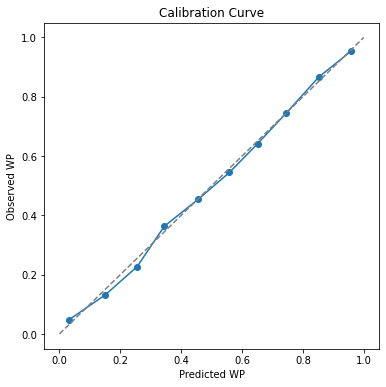

In [45]:
# Compute calibration, Brier score, reliability/resolution
# Bin predicted WP
bins = np.linspace(0, 1, 11)
wp_bin = pd.cut(pbp_fourth_test_tuned['wp_pred'], bins, include_lowest=True)

# Aggregate by bin
cal_table = pbp_fourth_test_tuned.groupby(wp_bin).agg(
    wp_pred_mean=('wp_pred', 'mean'),
    win_rate=('win_actual', 'mean'),
    count=('win_actual', 'count')
).reset_index()

# Brier score
brier = np.mean((pbp_fourth_test_tuned['wp_pred'] - pbp_fourth_test_tuned['win_actual'])**2)

# Reliability and resolution
N = len(pbp_fourth_test_tuned)
reliability = np.sum(cal_table['count'] / N * (cal_table['wp_pred_mean'] - cal_table['win_rate'])**2)
resolution = np.sum(cal_table['count'] / N * (cal_table['win_rate'] - pbp_fourth_test_tuned['win_actual'].mean())**2)
uncertainty = np.mean(pbp_fourth_test_tuned['win_actual']) * (1 - np.mean(pbp_fourth_test_tuned['win_actual']))
brier_check = reliability - resolution + uncertainty

# Print results
print(f"Brier score: {brier:.5f}")
print(f"Reliability: {reliability:.5f}")
print(f"Resolution: {resolution:.5f}")
print(f"Uncertainty: {uncertainty:.5f}")
print(f"Brier check (reliability - resolution + uncertainty): {brier_check:.5f}")

# Plot calibration
x = cal_table['wp_pred_mean'].values.ravel()  # ensures 1D
y = cal_table['win_rate'].values.ravel()     # ensures 1D

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Predicted WP')
plt.ylabel('Observed WP')
plt.title('Calibration Curve')
plt.show()

In [46]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.032528,0.048780,492
1,"(0.1, 0.2]",0.150412,0.131673,281
2,"(0.2, 0.3]",0.255211,0.227011,348
3,"(0.3, 0.4]",0.344345,0.362924,383
4,"(0.4, 0.5]",0.456683,0.455056,534
5,"(0.5, 0.6]",0.558515,0.544643,448
6,"(0.6, 0.7]",0.651512,0.642173,313
7,"(0.7, 0.8]",0.744190,0.743772,281
8,"(0.8, 0.9]",0.852260,0.866667,270
9,"(0.9, 1.0]",0.957016,0.952802,339


In [47]:
bins = np.linspace(0, 1, 11)
calibration_df = pd.DataFrame(index=pd.IntervalIndex.from_tuples([(round(bins[i],2), round(bins[i+1],2)) for i in range(len(bins)-1)]))

# Function to compute empirical win fraction per bin
def empirical_win_fraction(pred_col):
    return pbp_fourth_test_tuned.groupby(pd.cut(pbp_fourth_test_tuned[pred_col], bins=bins))['win_actual'].mean()

# Compute results for each play type
calibration_df['ewp_punt'] = round(empirical_win_fraction('ewp_punt'),3)
calibration_df['ewp_fg'] = round(empirical_win_fraction('ewp_fg'),3)
calibration_df['ewp_go_adj'] = round(empirical_win_fraction('ewp_go_adj'),3)

# Bins indicate predicted wp bin; columns are how often a team actually won in that predicted wp bin
calibration_df

,ewp_punt,ewp_fg,ewp_go_adj
"(0.0, 0.1]",0.045,0.059,0.047
"(0.1, 0.2]",0.143,0.136,0.147
"(0.2, 0.3]",0.298,0.296,0.258
"(0.3, 0.4]",0.375,0.425,0.387
"(0.4, 0.5]",0.500,0.542,0.476
"(0.5, 0.6]",0.519,0.540,0.548
"(0.6, 0.7]",0.647,0.639,0.642
"(0.7, 0.8]",0.789,0.761,0.783
"(0.8, 0.9]",0.870,0.880,0.874
"(0.9, 1.0]",0.955,0.971,0.948


In [48]:
ewp_columns = ['ewp_punt', 'ewp_fg', 'ewp_go_adj']

# Boolean mask of violations
violation_mask = (pbp_fourth_test_tuned[ewp_columns] < 0) | (pbp_fourth_test_tuned[ewp_columns] > 1)

# Count violations per column
violations = violation_mask.sum()

if violations.sum() == 0:
    print("No EWP violations detected.")
else:
    print("Violations detected:")
    print(violations)
    print(pbp_fourth_test_tuned[violation_mask.any(axis=1)].head())

No EWP violations detected.


In [49]:
state = pbp_fourth_test_tuned[wp_features]
state_flipped = state.copy()
state_flipped["score_differential"] *= -1
state_flipped[["posteam_timeouts_remaining","defteam_timeouts_remaining"]] = (
    state_flipped[["defteam_timeouts_remaining","posteam_timeouts_remaining"]].values
)
state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
state_flipped["score_time_ratio"] = state_flipped["score_differential"].abs() / (state_flipped["game_seconds_remaining"] + 1)

wp = wp_symmetric_adjust(state, predict_wp)
wp_flipped = wp_symmetric_adjust(state_flipped, predict_wp)
flip_err = wp + wp_flipped - 1

flip_err.mean()

0.014979305

In [50]:
# Conditional mean regret
pbp_fourth_test_tuned[pbp_fourth_test_tuned.follow_model == 0].regret_actual.mean()

0.012892806267925624

In [51]:
# Compute regret stats by play type ---
df_disagree = pbp_fourth_test_tuned[pbp_fourth_test_tuned["disagreed"] == True].copy()
regret_by_play = df_disagree.groupby('play_type_actual')['regret_actual'].agg(['mean', 'median'])
df_disagree['regret_actual'] = pd.to_numeric(df_disagree['regret_actual'], errors='coerce')

# Compute stats
regret_by_play = df_disagree.groupby('play_type_actual')['regret_actual'].agg(['size', 'mean', 'median'])
regret_by_play['95th'] = df_disagree.groupby('play_type_actual')['regret_actual'].quantile(0.95)

print("Regret by Play Type Conditioned on Coach Disagreement:")
regret_by_play

Regret by Play Type Conditioned on Coach Disagreement:


,size,mean,median,95th
play_type_actual,,,,
field_goal,209,0.008590,0.006628,0.024137
go,500,0.015985,0.011732,0.049648
punt,341,0.010997,0.007907,0.032137


In [52]:
# Regret vs margin for disagreements
disagree_bins = pd.qcut(df_disagree["decision_margin"], q=10, duplicates="drop")
regret_by_margin = df_disagree.groupby(disagree_bins)["regret_actual"].agg(
    mean="mean",
    p95=lambda x: np.percentile(x, 95),
    count="count"
)
print("Regret vs Decision Margin (Disagreements)")
display(regret_by_margin)

# Bin decision margin
pbp_fourth_test_tuned["margin_bin"] = pd.qcut(pbp_fourth_test_tuned["decision_margin"], 10)
follow_by_margin = pbp_fourth_test_tuned.groupby("margin_bin").agg(
    follow_rate=("follow_model", "mean"),
    count=("follow_model", "size")
)
print("Follow Model Rate vs Decision Margin")
follow_by_margin

Regret vs Decision Margin (Disagreements)


,mean,p95,count
decision_margin,,,
"(-0.001, 0.000888]",0.001434,0.010106,105
"(0.000888, 0.00225]",0.002237,0.008173,105
"(0.00225, 0.00371]",0.003494,0.006076,105
"(0.00371, 0.00576]",0.006116,0.013940,105
"(0.00576, 0.008]",0.008097,0.012072,105
"(0.008, 0.0108]",0.010291,0.012773,105
"(0.0108, 0.0141]",0.013420,0.017863,105
"(0.0141, 0.0181]",0.016493,0.018097,105
"(0.0181, 0.0266]",0.022805,0.026557,105


Follow Model Rate vs Decision Margin


,follow_rate,count
margin_bin,,
"(-0.001, 0.00233]",0.406504,369
"(0.00233, 0.00544]",0.514905,369
"(0.00544, 0.00858]",0.579946,369
"(0.00858, 0.0123]",0.661247,369
"(0.0123, 0.0163]",0.677507,369
"(0.0163, 0.0216]",0.752717,368
"(0.0216, 0.0288]",0.796748,369
"(0.0288, 0.0408]",0.869919,369
"(0.0408, 0.0624]",0.940379,369


In [53]:
df_disagree[(df_disagree.decision_margin > .05)].groupby('recommended_play')['regret_actual'].agg(['mean', 'size'])

,mean,size
recommended_play,,
field_goal,0.063100,10
go,0.059106,2
punt,0.081787,13


In [54]:
test = pbp_fourth_test_tuned[pbp_fourth_test_tuned.season == test_season]

labels = ["punt", "field_goal", "go"]

cm_df = test[["play_type_actual", "recommended_play"]].dropna()

cm = confusion_matrix(
    cm_df["play_type_actual"].astype(str),
    cm_df["recommended_play"].astype(str),
    labels=labels
)

confusion = pd.DataFrame(
    cm,
    index=pd.Index(labels, name="Actual"),
    columns=pd.Index(labels, name="Recommended")
)

confusion

Recommended,punt,field_goal,go
Actual,,,
punt,1457,51,290
field_goal,58,785,151
go,286,214,397


In [55]:
confusion_norm = confusion.div(confusion.sum(axis=1), axis=0)
round(confusion_norm,4)

Recommended,punt,field_goal,go
Actual,,,
punt,0.8103,0.0284,0.1613
field_goal,0.0584,0.7897,0.1519
go,0.3188,0.2386,0.4426


In [56]:
def p_go_from_margin(margin, scale):
    return 1 / (1 + np.exp(-margin / scale))

In [57]:
df = pbp_fourth_test_tuned.copy()

In [58]:
df["p_go_model"] = p_go_from_margin(
    df["go_margin"],
    scale=0.0075
).clip(.01, .99)

df["coach_go"] = (
    df["play_type_actual"] == "go"
).astype(int)


df["go_diff"] = (
    df["coach_go"]
    - df["p_go_model"]
)

rai_raw = (
    df
    .groupby("possession_coach")
    .agg(
        rai=("go_diff", "mean"),
        n=("go_diff", "size")
    )
    .sort_values("rai")
)

k = 30  # prior strength
rai_raw["rai_shrunk"] = (
    rai_raw["n"] / (rai_raw["n"] + k)
) * rai_raw["rai"]

In [59]:
rai_raw.sort_values("rai_shrunk", ascending=False).head(10)

,rai,n,rai_shrunk
possession_coach,,,
Aaron Glenn,0.050830,134,0.041532
Kellen Moore,0.043372,127,0.035084
Brian Callahan,0.031170,140,0.025669
Pete Carroll,0.031643,118,0.025229
Dave Canales,0.030551,125,0.024638
Raheem Morris,0.024729,124,0.019912
Brian Schottenheimer,0.019923,109,0.015623
Jonathan Gannon,0.009544,111,0.007514
Sean McDermott,0.007095,99,0.005445


In [60]:
rai_raw.sort_values("rai_shrunk").head(10)

,rai,n,rai_shrunk
possession_coach,,,
Mike Macdonald,-0.166522,101,-0.128387
Kyle Shanahan,-0.143060,95,-0.108726
DeMeco Ryans,-0.131012,138,-0.107617
Kevin O'Connell,-0.105261,114,-0.083332
Sean Payton,-0.093236,112,-0.073538
Dan Quinn,-0.092867,102,-0.071761
Mike Tomlin,-0.083738,118,-0.066764
Mike Vrabel,-0.082012,101,-0.063230
Jim Harbaugh,-0.069268,122,-0.055597


In [61]:
yard_edges  = list(range(1, 101, 10)) + [101]
yard_labels = [f"{start}–{start+9}" for start in yard_edges[:-1]]

df["yardline_bin"] = pd.cut(
    df["yardline_100"],
    bins=yard_edges,
    labels=yard_labels,
    right=False,
    include_lowest=True
)


togo_bins   = [0, 1, 3, 6, 9, np.inf]
togo_labels = ["1", "2–3", "4–6", "7–9", "10+"]

df["ydstogo_bin"] = pd.cut(
    df["ydstogo"],
    bins=togo_bins,
    labels=togo_labels,
    right=True,
    include_lowest=True
)

In [62]:
heat = (
    df
    .groupby(["ydstogo_bin", "yardline_bin"], observed=False)["go_diff"]
    .mean()
    .unstack("yardline_bin")
)

counts = (
    df
    .groupby(["ydstogo_bin", "yardline_bin"], observed=False)["go_diff"]
    .size()
    .unstack("yardline_bin")
)

min_n = 10
heat = heat.mask(counts < min_n)

round(heat,3)

yardline_bin,1–10,11–20,21–30,31–40,41–50,51–60,61–70,71–80,81–90,91–100
ydstogo_bin,,,,,,,,,,
1,0.187,0.416,0.379,0.308,0.222,0.234,0.066,-0.171,-0.326,NaN
2–3,0.035,0.105,0.212,0.182,0.128,-0.113,-0.198,-0.246,-0.090,NaN
4–6,-0.175,-0.174,-0.001,0.126,-0.272,-0.145,-0.135,-0.158,-0.099,NaN
7–9,-0.179,-0.111,-0.108,-0.086,-0.241,-0.145,-0.139,-0.134,-0.112,NaN
10+,NaN,-0.056,-0.025,0.005,-0.046,-0.002,0.016,-0.024,-0.035,-0.021


In [64]:
p = pbp_fourth_test_tuned["wp_current"].to_numpy()  # or whatever column you binned on
print("N:", len(p))
print("min/max:", p.min(), p.max())
print("pct <0.1:", (p < 0.1).mean())
print("pct >0.9:", (p > 0.9).mean())
print("quantiles:", np.quantile(p, [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]))
print("down counts:\n", pbp_fourth_test_tuned["down"].value_counts(normalize=True).sort_index())
print("time quantiles:", np.quantile(pbp_fourth_test_tuned["game_seconds_remaining"], [0.01,0.1,0.5,0.9,0.99]))


N: 3689
min/max: 0.0 1.0
pct <0.1: 0.13336947682298725
pct >0.9: 0.09189482244510708
quantiles: [5.70403133e-04 6.49603046e-03 5.89051694e-02 2.54675329e-01
 4.70817447e-01 6.90774798e-01 8.89836502e-01 9.57315361e-01
 9.96032221e-01]
down counts:
 down
4.0    1.0
Name: proportion, dtype: float64
time quantiles: [  20.88  201.   1711.   3131.2  3510.  ]


In [66]:
wp_raw = predict_wp(pbp_fourth_test_tuned)              # no symmetry adjustment
wp_adj = wp_symmetric_adjust(pbp_fourth_test_tuned, predict_wp)

print("raw min/max:", wp_raw.min(), wp_raw.max())
print("adj min/max:", wp_adj.min(), wp_adj.max())
print("raw pct <0.1:", (wp_raw < 0.1).mean(), " raw pct >0.9:", (wp_raw > 0.9).mean())
print("adj pct <0.1:", (wp_adj < 0.1).mean(), " adj pct >0.9:", (wp_adj > 0.9).mean())


raw min/max: 0.0 1.0
adj min/max: 0.0 1.0
raw pct <0.1: 0.13336947682298725  raw pct >0.9: 0.09081051775548929
adj pct <0.1: 0.13336947682298725  adj pct >0.9: 0.09189482244510708


In [69]:
wp_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04109634909948537,
             max_bin=None, m...ne, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=54, missing=nan,
             monotone_constraints={'defteam_timeouts_remaining': -1, 'down': -1,
                                   'posteam_timeouts_remaining': 1,
                                   'score_differential': 1, 'yardline_100': -1,
                                   'ydstogo': -1},
             multi_strategy=None, n_estimators=252, n_jobs=None,
             num_parallel_tree=